# Simplicial Interpolation WIP #




In [9]:
import numpy
from scipy.spatial import Delaunay

def point_line_3d(point, line):
    return numpy.linalg.norm(numpy.cross(line[1]-line[0], line[0]-point)) / numpy.linalg.norm(line[1]-line[0])
    
def point_line_2d(x1, y1, x2, y2, x3, y3): # x3,y3 is the point
    # @ref: https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
    
    px = x2-x1
    py = y2-y1

    norm = px*px + py*py

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    # Note: If the actual distance does not matter,
    # if you only want to compare what this function
    # returns to other results of this function, you
    # can just return the squared distance instead
    # (i.e. remove the sqrt) to gain a little performance
    dist = (dx*dx + dy*dy)**.5

    return dist

def simplicial(current_node, tesselation, values):    
    '''
    tesselation = Delaunay(nodes)
    '''
    
    index = tesselation.find_simplex(current_node)
    
    # inside convex hull
    if index != -1:
        
        # find barycentric coordinates
        nd = len(current_node)
        coordinates = tesselation.transform[index,:nd].dot(current_node - tesselation.transform[index,nd])
        coordinates = numpy.hstack((coordinates, 1-numpy.sum(coordinates)))
        
        # interpolate values
        vertices = tesselation.simplices[index]
        return numpy.sum(values[vertices] * numpy.array(coordinates).reshape(-1,1), axis=0)
    
    # outside convex hull
    else:
        # find points in convex_hull
        convex_hull_points = tesselation.points[tesselation.convex_hull]
        
        # 2D
        if len(current_node) == 2:
            # find closest convex_hull line
            closest_line = numpy.argmin([point_line_2d(line[0][0], line[0][1], line[1][0], line[1][1], current_node[0], current_node[1]) for line in convex_hull_points])
            closest_line_points = convex_hull_points[closest_line] # points on closest-line
            #closest_line_point_ids = tesselation.convex_hull[closest_line]
            
            weight = numpy.dot(current_node-closest_line_points[0], closest_line_points[1]-closest_line_points[0]) \
                     / numpy.linalg.norm(closest_line_points[1]-closest_line_points[0])
            #print weight
            return values[tesselation.convex_hull[closest_line][1]] * weight + values[tesselation.convex_hull[closest_line][0]] * (1-weight)
        
        else:
            raise NotImplementedError()
        
        
        '''
        # simplex distances
        distances = tesselation.plane_distance(numpy.array(current_node))
        closest_simplex = numpy.argmax(distances)
        #print distances, closest_simplex
        # interpolate values
        vertices = tesselation.simplices[closest_simplex]
        closest_vertex = vertices[0]
        #vertex_distances = numpy.sum((tesselation.points[vertices] - current_node)**2, axis=1)
        #closest_vertex = numpy.argmin(vertex_distances)
    
        return values[closest_vertex]
        #return values[vertices[0]]
        '''

# generate data
nodes = numpy.random.random((10, 2))
values = numpy.random.random((10, 3))

tesselation = Delaunay(nodes)
print simplicial([0.,0.5], tesselation, values)


[0.7362918  0.82513326 0.40218468]


Text(0,0.5,'Y')

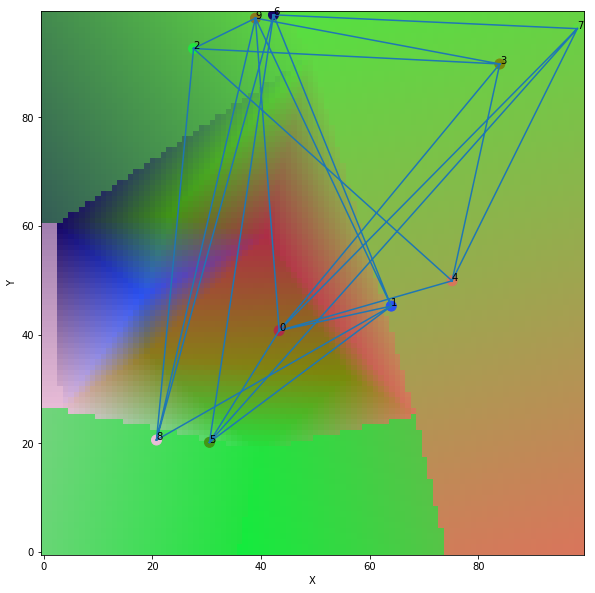

In [8]:
import colorsys
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap

# generate data
nodes = numpy.random.random((10, 2))
values = numpy.random.random((10, 3))

# create NxN grid
N = 100
ti = numpy.linspace(0, 1, N)

# create plot figures
f = pyplot.figure(figsize=(10,10))
ax1 = f.add_subplot(1,1,1)

# ======
#tesselation = Delaunay(nodes)
data = numpy.array([simplicial([ti[j],ti[i]], tesselation, values) for i in range(N) for j in range(N)])

ax1.scatter(nodes[:,0]*N, nodes[:,1]*N, s=100, c=values)#, edgecolor='black', zorder=10) # points
for i,node in enumerate(nodes):
    ax1.text(node[0]*N, node[1]*N, str(i), zorder=20)
    
ax1.triplot(nodes[:,0]*N, nodes[:,1]*N, tesselation.simplices.copy()) # wireframe
ax1.imshow(data.reshape(N,N,3), interpolation='none', origin='lower')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# 
#simplicial

#n = len(tri.points)
#rgb = numpy.random.random((n, 3))
#z = numpy.arange(n)
#cmap = LinearSegmentedColormap.from_list('mymap', rgb, N=len(rgb))

#pyplot.tripcolor(nodes[:,0], nodes[:,1], tri.simplices.copy(), z, shading='gouraud', cmap=cmap) # vertex color
#pyplot.triplot(nodes[:,0], nodes[:,1], tri.simplices.copy(), alpha=1) # wireframe
#pyplot.scatter(nodes[:,0], nodes[:,1], s=50, c=rgb, edgecolor='black', zorder=10) # points
